In [ ]:
!pip install q keras==2.3.1

In [ ]:
pip install talos

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import sklearn
import sklearn.datasets
import tensorflow as tf
import keras
from tensorflow import keras
from tensorflow.python.keras.layers import Input, Dense
from tensorflow.python.keras import Sequential
from tensorflow.python.keras import regularizers
from keras.layers.normalization.batch_normalization import BatchNormalization
from tensorboard.plugins.hparams import api as hp
from tensorflow.python.keras.optimizer_v2.adam import Adam
from tensorflow.python.keras.optimizer_v2.rmsprop import RMSprop
from tensorflow.python.keras.optimizer_v2.nadam import Nadam
from tensorflow.python.keras.optimizer_v2.adamax import Adamax

In [ ]:
#import talos library (after install keras and talos)
import talos as ta
from talos.utils import lr_normalizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Bank Customer Churn Prediction.csv')
df.head(5)


,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
df.nunique()

customer_id         10000
credit_score          460
country                 3
gender                  2
age                    70
tenure                 11
balance              6382
products_number         4
credit_card             2
active_member           2
estimated_salary     9999
churn                   2
dtype: int64

In [ ]:
df = df.drop(['customer_id'], axis = 1)
continuous_vars = ['credit_score', 'age', 'tenure', 'balance', 'products_number', 'estimated_salary']
categorical_vars = ['country', 'gender', 'credit_card', 'active_member']
df = df[['churn'] + continuous_vars + categorical_vars]
df.head()

,churn,credit_score,age,tenure,balance,products_number,estimated_salary,country,gender,credit_card,active_member
0,1,619,42,2,0.00,1,101348.88,France,Female,1,1
1,0,608,41,1,83807.86,1,112542.58,Spain,Female,0,1
2,1,502,42,8,159660.80,3,113931.57,France,Female,1,0
3,0,699,39,1,0.00,2,93826.63,France,Female,0,0
4,0,850,43,2,125510.82,1,79084.10,Spain,Female,1,1


In [ ]:
# Changing values of column credit_card and active_member from 0 to -1 so that they will influence negatively to the model instead of no effect.
df.loc[df.credit_card == 0, 'credit_card'] = -1
df.loc[df.active_member == 0, 'active_member'] = -1
df.head()

,churn,credit_score,age,tenure,balance,products_number,estimated_salary,country,gender,credit_card,active_member
0,1,619,42,2,0.00,1,101348.88,France,Female,1,1
1,0,608,41,1,83807.86,1,112542.58,Spain,Female,-1,1
2,1,502,42,8,159660.80,3,113931.57,France,Female,1,-1
3,0,699,39,1,0.00,2,93826.63,France,Female,-1,-1
4,0,850,43,2,125510.82,1,79084.10,Spain,Female,1,1


In [ ]:
df = pd.get_dummies(df, columns = ['country', 'gender'])
df.head()

,churn,credit_score,age,tenure,balance,products_number,estimated_salary,credit_card,active_member,country_France,country_Germany,country_Spain,gender_Female,gender_Male
0,1,619,42,2,0.00,1,101348.88,1,1,1,0,0,1,0
1,0,608,41,1,83807.86,1,112542.58,-1,1,0,0,1,1,0
2,1,502,42,8,159660.80,3,113931.57,1,-1,1,0,0,1,0
3,0,699,39,1,0.00,2,93826.63,-1,-1,1,0,0,1,0
4,0,850,43,2,125510.82,1,79084.10,1,1,0,0,1,1,0


In [ ]:
continuous_vars

['credit_score',
 'age',
 'tenure',
 'balance',
 'products_number',
 'estimated_salary']

In [ ]:
scaler = StandardScaler()
df[continuous_vars] = scaler.fit_transform(df[continuous_vars])
df.head

<bound method NDFrame.head of       churn  credit_score       age    tenure   balance  products_number  \
0         1     -0.326221  0.293517 -1.041760 -1.225848        -0.911583   
1         0     -0.440036  0.198164 -1.387538  0.117350        -0.911583   
2         1     -1.536794  0.293517  1.032908  1.333053         2.527057   
3         0      0.501521  0.007457 -1.387538 -1.225848         0.807737   
4         0      2.063884  0.388871 -1.041760  0.785728        -0.911583   
...     ...           ...       ...       ...       ...              ...   
9995      0      1.246488  0.007457 -0.004426 -1.225848         0.807737   
9996      0     -1.391939 -0.373958  1.724464 -0.306379        -0.911583   
9997      1      0.604988 -0.278604  0.687130 -1.225848        -0.911583   
9998      1      1.256835  0.293517 -0.695982 -0.022608         0.807737   
9999      0      1.463771 -1.041433 -0.350204  0.859965        -0.911583   

      estimated_salary  credit_card  active_member  count

In [ ]:
for col in df:
    print(f'{col}: {df[col].unique()}')

churn: [1 0]
credit_score: [-0.32622142 -0.44003595 -1.53679418  0.50152063  2.06388377 -0.05720525
  1.77417405 -2.84048792 -1.54714096  0.346319   -1.26777801 -1.58852806
 -1.80581035 -1.05049572 -0.16067301 -0.35726175  0.02556895 -0.65731824
  0.78088358  0.84296423 -0.15032623 -1.45401997  0.19111736  2.02249666
 -0.760786    1.09128685 -0.82286666 -0.79182633 -2.47835077 -0.61593114
 -1.21604413 -1.00910862 -1.35055222  0.73949648 -1.81615712 -1.66095549
  1.58793208 -0.70905212 -1.84719745 -1.91962488 -0.97806829  1.89833536
  0.09799638  1.29822236  1.84660148 -0.13997946 -1.04014895  0.49117386
 -0.6780118   1.42238367  0.0462625  -0.51246338  0.05660928  0.7705368
 -1.4436732  -0.3779553   0.94643199  0.37735933 -0.98841507 -0.49176983
  1.03955297 -0.7193989   0.87400456  0.10834316  0.25319802  0.90504489
  1.68105307  0.06695605 -0.48142306 -1.36089899  0.13938348  0.28423834
  1.10163363 -2.42661689  0.14973026  1.30856914 -1.11257638 -1.49540708
 -1.62991516  0.01522218 

In [ ]:
Y=df['churn']
X= df.drop(labels='churn', axis='columns')

In [ ]:
df=df.to_numpy()
df

array([[ 1.        , -0.32622142,  0.29351742, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.        , -0.44003595,  0.19816383, ...,  1.        ,
         1.        ,  0.        ],
       [ 1.        , -1.53679418,  0.29351742, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 1.        ,  0.60498839, -0.27860412, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.        ,  1.25683526,  0.29351742, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.        ,  1.46377078, -1.04143285, ...,  0.        ,
         1.        ,  0.        ]])

In [ ]:
Y=Y.to_numpy()
Y

array([1, 0, 1, ..., 1, 1, 0])

In [ ]:
X=X.to_numpy()
X

array([[-0.32622142,  0.29351742, -1.04175968, ...,  0.        ,
         1.        ,  0.        ],
       [-0.44003595,  0.19816383, -1.38753759, ...,  1.        ,
         1.        ,  0.        ],
       [-1.53679418,  0.29351742,  1.03290776, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.60498839, -0.27860412,  0.68712986, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.25683526,  0.29351742, -0.69598177, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.46377078, -1.04143285, -0.35020386, ...,  0.        ,
         1.        ,  0.        ]])

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=30, test_size = .2)



In [ ]:
X_train_tf = tf.stack(X_train)
Y_train_tf = tf.stack(Y_train)
X_test_tf = tf.stack(X_test)
Y_test_tf = tf.stack(Y_test)

In [ ]:
X_train.shape

(8000, 13)

In [ ]:
Y_train

array([0, 0, 1, ..., 0, 0, 0])

In [ ]:
X_test

array([[-1.17465703,  2.5820036 ,  1.03290776, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.49117386,  1.62846769, -1.38753759, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.19111736,  0.5795782 ,  0.68712986, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.7193989 , -0.85072567, -1.38753759, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.60498839,  0.00745665,  1.03290776, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.95006923,  1.15169974, -0.69598177, ...,  0.        ,
         1.        ,  0.        ]])

In [ ]:
Y_test

array([0, 1, 0, ..., 0, 0, 1])

***Hyperparamter tuning using random search with the random method "quantum"***


In [ ]:
from tensorflow.python.keras.optimizer_v2 import adam as adam_v2
from tensorflow.python.keras.optimizer_v2 import optimizer_v2

In [ ]:
#We set the parameter space
p = {'lr': [0.01, 0.1],
     'first_neuron':[32, 64],
     'hidden_layers':[2, 3, 4, 5],
     'batch_size': [32, 64],
     'epochs': [100],
     'dropout': [0, 0.5],
     'weight_regulizer':['GlorotNormal', 'HeNormal'],
     'shape':['brick','long_funnel'],
     'optimizer': ['Adam', 'Nadam', 'Adamax'],
     'losses': ['logcosh', 'binary_crossentropy'],
     'activation':['relu', 'elu'],
     'last_activation': ['sigmoid']}

In [ ]:
# determine the number of input features
n_features = X_train.shape[1]


# defining/creating a sequential model

def achraf_model(X_train, Y_train, X_test, Y_test, params): 
  model = Sequential()
  model.add(Dense(params['first_neuron'], kernel_initializer=params['weight_regulizer'], kernel_regularizer=regularizers.l2(0.09), input_shape=(n_features,), activation=params['activation']))
  BatchNormalization()
  model.add(Dense(77, kernel_initializer=params['weight_regulizer'], kernel_regularizer=regularizers.l2(0.08), activation=params['activation']))
  BatchNormalization()
  model.add(Dense(70, kernel_initializer=params['weight_regulizer'], kernel_regularizer=regularizers.l2(0.07), activation=params['activation']))
  BatchNormalization()
  model.add(Dense(70,  kernel_initializer=params['weight_regulizer'], kernel_regularizer=regularizers.l2(0.06), activation=params['activation']))
  BatchNormalization()
  model.add(Dense(63, kernel_initializer=params['weight_regulizer'], activation=params['activation']))
  BatchNormalization(
              momentum=0.95, 
              epsilon=0.005,
              center = True,
              scale = True,
              beta_initializer='zeros', 
              gamma_initializer='ones',
              moving_mean_initializer='zeros',
            moving_variance_initializer='ones',
            beta_regularizer=None,
            gamma_regularizer=None,
            beta_constraint=None,
            gamma_constraint=None,
            ),
  model.add(Dense(1, activation=params['last_activation'], name="predictions"))

  model.compile(optimizer=params['optimizer'], loss=params['losses'], metrics=['accuracy'])
  model.summary

  history = model.fit(
    X_train, 
    Y_train, 
    epochs=51, 
    validation_split=0.25, 
    batch_size=32, 
    verbose=2,
    validation_data=(X_test, Y_test)
)
  
  return history, model

In [ ]:
#Hyperparamter tuning using random search with the random method "quantum"
scan_object = ta.Scan(x = X_train,
            y = Y_train,
            x_val=X_test,
            y_val=Y_test,
            params=p,
            model = achraf_model,
            experiment_name='churn',
            random_method='quantum',
            fraction_limit = 0.01)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/51
188/188 - 3s - loss: 6.9104 - accuracy: 0.7917 - val_loss: 1.8544 - val_accuracy: 0.8085
Epoch 2/51
188/188 - 1s - loss: 0.9964 - accuracy: 0.7968 - val_loss: 0.5907 - val_accuracy: 0.8095
Epoch 3/51
188/188 - 1s - loss: 0.5540 - accuracy: 0.7968 - val_loss: 0.4995 - val_accuracy: 0.8090
Epoch 4/51
188/188 - 0s - loss: 0.5179 - accuracy: 0.7975 - val_loss: 0.4923 - val_accuracy: 0.8095
Epoch 5/51
188/188 - 1s - loss: 0.5103 - accuracy: 0.7998 - val_loss: 0.4913 - val_accuracy: 0.8175
Epoch 6/51
188/188 - 1s - loss: 0.5043 - accuracy: 0.8018 - val_loss: 0.4750 - val_accuracy: 0.8080
Epoch 7/51
188/188 - 1s - loss: 0.4998 - accuracy: 0.8022 - val_loss: 0.4680 - val_accuracy: 0.8125
Epoch 8/51
188/188 - 0s - loss: 0.4956 - accuracy: 0.8007 - val_loss: 0.4884 - val_accuracy: 0.8085
Epoch 9/51
188/188 - 0s - loss: 0.4934 - accuracy: 0.8013 - val_loss: 0.4599 - val_accuracy: 0.8210
Epoch 10/51
188/188 - 1s - loss: 0.4887 - accuracy: 0.8033 - val_loss: 0.4567 - val_accuracy: 0.8160

  3%|▎         | 1/30 [00:43<20:59, 43.44s/it]

Epoch 1/51
188/188 - 2s - loss: 22.9144 - accuracy: 0.7907 - val_loss: 13.2793 - val_accuracy: 0.8120
Epoch 2/51
188/188 - 1s - loss: 8.6475 - accuracy: 0.7985 - val_loss: 5.2425 - val_accuracy: 0.8095
Epoch 3/51
188/188 - 1s - loss: 3.5382 - accuracy: 0.7967 - val_loss: 2.2559 - val_accuracy: 0.8095
Epoch 4/51
188/188 - 0s - loss: 1.6281 - accuracy: 0.7967 - val_loss: 1.1367 - val_accuracy: 0.8095
Epoch 5/51
188/188 - 1s - loss: 0.9124 - accuracy: 0.7967 - val_loss: 0.7163 - val_accuracy: 0.8095
Epoch 6/51
188/188 - 0s - loss: 0.6437 - accuracy: 0.7967 - val_loss: 0.5606 - val_accuracy: 0.8095
Epoch 7/51
188/188 - 0s - loss: 0.5477 - accuracy: 0.7967 - val_loss: 0.5097 - val_accuracy: 0.8095
Epoch 8/51
188/188 - 0s - loss: 0.5174 - accuracy: 0.7967 - val_loss: 0.4933 - val_accuracy: 0.8095
Epoch 9/51
188/188 - 0s - loss: 0.5085 - accuracy: 0.7967 - val_loss: 0.4902 - val_accuracy: 0.8095
Epoch 10/51
188/188 - 0s - loss: 0.5062 - accuracy: 0.7967 - val_loss: 0.4876 - val_accuracy: 0.80

  7%|▋         | 2/30 [01:07<15:04, 32.32s/it]

Epoch 1/51
188/188 - 1s - loss: 20.0523 - accuracy: 0.8083 - val_loss: 9.4451 - val_accuracy: 0.8270
Epoch 2/51
188/188 - 1s - loss: 5.5054 - accuracy: 0.8073 - val_loss: 2.9434 - val_accuracy: 0.8095
Epoch 3/51
188/188 - 1s - loss: 1.9650 - accuracy: 0.7988 - val_loss: 1.2698 - val_accuracy: 0.8135
Epoch 4/51
188/188 - 0s - loss: 1.0017 - accuracy: 0.7982 - val_loss: 0.7681 - val_accuracy: 0.8085
Epoch 5/51
188/188 - 0s - loss: 0.6915 - accuracy: 0.8005 - val_loss: 0.5965 - val_accuracy: 0.8095
Epoch 6/51
188/188 - 0s - loss: 0.5832 - accuracy: 0.7980 - val_loss: 0.5276 - val_accuracy: 0.8085
Epoch 7/51
188/188 - 1s - loss: 0.5371 - accuracy: 0.8000 - val_loss: 0.5048 - val_accuracy: 0.8095
Epoch 8/51
188/188 - 1s - loss: 0.5187 - accuracy: 0.7987 - val_loss: 0.4904 - val_accuracy: 0.8130
Epoch 9/51
188/188 - 1s - loss: 0.5160 - accuracy: 0.8010 - val_loss: 0.4820 - val_accuracy: 0.8115
Epoch 10/51
188/188 - 1s - loss: 0.5043 - accuracy: 0.8003 - val_loss: 0.4723 - val_accuracy: 0.814

 10%|█         | 3/30 [01:36<13:46, 30.62s/it]

Epoch 1/51
188/188 - 3s - loss: 5.9150 - accuracy: 0.7863 - val_loss: 1.6990 - val_accuracy: 0.8095
Epoch 2/51
188/188 - 0s - loss: 0.9559 - accuracy: 0.7967 - val_loss: 0.5930 - val_accuracy: 0.8095
Epoch 3/51
188/188 - 0s - loss: 0.5472 - accuracy: 0.7967 - val_loss: 0.4991 - val_accuracy: 0.8095
Epoch 4/51
188/188 - 0s - loss: 0.5107 - accuracy: 0.7967 - val_loss: 0.4887 - val_accuracy: 0.8095
Epoch 5/51
188/188 - 1s - loss: 0.5065 - accuracy: 0.7967 - val_loss: 0.4872 - val_accuracy: 0.8095
Epoch 6/51
188/188 - 0s - loss: 0.5059 - accuracy: 0.7967 - val_loss: 0.4876 - val_accuracy: 0.8095
Epoch 7/51
188/188 - 1s - loss: 0.5059 - accuracy: 0.7967 - val_loss: 0.4873 - val_accuracy: 0.8095
Epoch 8/51
188/188 - 0s - loss: 0.5054 - accuracy: 0.7967 - val_loss: 0.4898 - val_accuracy: 0.8095
Epoch 9/51
188/188 - 1s - loss: 0.5060 - accuracy: 0.7967 - val_loss: 0.4872 - val_accuracy: 0.8095
Epoch 10/51
188/188 - 0s - loss: 0.5061 - accuracy: 0.7967 - val_loss: 0.4877 - val_accuracy: 0.8095

 13%|█▎        | 4/30 [02:04<12:46, 29.47s/it]

Epoch 1/51
188/188 - 2s - loss: 22.1426 - accuracy: 0.7967 - val_loss: 9.9356 - val_accuracy: 0.8090
Epoch 2/51
188/188 - 0s - loss: 5.6241 - accuracy: 0.7967 - val_loss: 2.8837 - val_accuracy: 0.8095
Epoch 3/51
188/188 - 1s - loss: 1.7894 - accuracy: 0.7967 - val_loss: 1.0370 - val_accuracy: 0.8095
Epoch 4/51
188/188 - 1s - loss: 0.6890 - accuracy: 0.7967 - val_loss: 0.4294 - val_accuracy: 0.8095
Epoch 5/51
188/188 - 0s - loss: 0.3018 - accuracy: 0.7967 - val_loss: 0.2008 - val_accuracy: 0.8095
Epoch 6/51
188/188 - 1s - loss: 0.1550 - accuracy: 0.7967 - val_loss: 0.1149 - val_accuracy: 0.8095
Epoch 7/51
188/188 - 1s - loss: 0.1011 - accuracy: 0.7967 - val_loss: 0.0847 - val_accuracy: 0.8095
Epoch 8/51
188/188 - 1s - loss: 0.0826 - accuracy: 0.7967 - val_loss: 0.0747 - val_accuracy: 0.8095
Epoch 9/51
188/188 - 1s - loss: 0.0769 - accuracy: 0.7967 - val_loss: 0.0718 - val_accuracy: 0.8095
Epoch 10/51
188/188 - 1s - loss: 0.0753 - accuracy: 0.7967 - val_loss: 0.0711 - val_accuracy: 0.809

 17%|█▋        | 5/30 [02:47<14:18, 34.35s/it]

Epoch 1/51
188/188 - 2s - loss: 6.8717 - accuracy: 0.7965 - val_loss: 1.8213 - val_accuracy: 0.8095
Epoch 2/51
188/188 - 1s - loss: 0.9649 - accuracy: 0.7967 - val_loss: 0.5663 - val_accuracy: 0.8095
Epoch 3/51
188/188 - 1s - loss: 0.5309 - accuracy: 0.7967 - val_loss: 0.4963 - val_accuracy: 0.8095
Epoch 4/51
188/188 - 1s - loss: 0.5071 - accuracy: 0.7967 - val_loss: 0.4872 - val_accuracy: 0.8095
Epoch 5/51
188/188 - 0s - loss: 0.5059 - accuracy: 0.7967 - val_loss: 0.4891 - val_accuracy: 0.8095
Epoch 6/51
188/188 - 0s - loss: 0.5059 - accuracy: 0.7967 - val_loss: 0.4880 - val_accuracy: 0.8095
Epoch 7/51
188/188 - 0s - loss: 0.5059 - accuracy: 0.7967 - val_loss: 0.4872 - val_accuracy: 0.8095
Epoch 8/51
188/188 - 1s - loss: 0.5059 - accuracy: 0.7967 - val_loss: 0.4900 - val_accuracy: 0.8095
Epoch 9/51
188/188 - 0s - loss: 0.5059 - accuracy: 0.7967 - val_loss: 0.4892 - val_accuracy: 0.8095
Epoch 10/51
188/188 - 1s - loss: 0.5056 - accuracy: 0.7967 - val_loss: 0.4895 - val_accuracy: 0.8095

 20%|██        | 6/30 [03:15<12:53, 32.22s/it]

Epoch 1/51
188/188 - 1s - loss: 23.3847 - accuracy: 0.7888 - val_loss: 11.4261 - val_accuracy: 0.8100
Epoch 2/51
188/188 - 0s - loss: 6.6812 - accuracy: 0.7965 - val_loss: 3.4937 - val_accuracy: 0.8095
Epoch 3/51
188/188 - 0s - loss: 2.1097 - accuracy: 0.7967 - val_loss: 1.1493 - val_accuracy: 0.8095
Epoch 4/51
188/188 - 0s - loss: 0.7160 - accuracy: 0.7967 - val_loss: 0.4060 - val_accuracy: 0.8095
Epoch 5/51
188/188 - 0s - loss: 0.2681 - accuracy: 0.7967 - val_loss: 0.1658 - val_accuracy: 0.8095
Epoch 6/51
188/188 - 1s - loss: 0.1263 - accuracy: 0.7967 - val_loss: 0.0936 - val_accuracy: 0.8095
Epoch 7/51
188/188 - 0s - loss: 0.0860 - accuracy: 0.7967 - val_loss: 0.0752 - val_accuracy: 0.8095
Epoch 8/51
188/188 - 0s - loss: 0.0766 - accuracy: 0.7967 - val_loss: 0.0714 - val_accuracy: 0.8095
Epoch 9/51
188/188 - 0s - loss: 0.0749 - accuracy: 0.7967 - val_loss: 0.0710 - val_accuracy: 0.8095
Epoch 10/51
188/188 - 0s - loss: 0.0747 - accuracy: 0.7967 - val_loss: 0.0709 - val_accuracy: 0.80

 23%|██▎       | 7/30 [03:39<11:21, 29.63s/it]

Epoch 1/51
188/188 - 2s - loss: 20.9761 - accuracy: 0.8028 - val_loss: 10.1437 - val_accuracy: 0.8320
Epoch 2/51
188/188 - 1s - loss: 5.9333 - accuracy: 0.8013 - val_loss: 3.1774 - val_accuracy: 0.8220
Epoch 3/51
188/188 - 0s - loss: 2.0771 - accuracy: 0.7975 - val_loss: 1.3110 - val_accuracy: 0.8090
Epoch 4/51
188/188 - 1s - loss: 1.0127 - accuracy: 0.7963 - val_loss: 0.7715 - val_accuracy: 0.8095
Epoch 5/51
188/188 - 1s - loss: 0.6870 - accuracy: 0.7963 - val_loss: 0.5910 - val_accuracy: 0.8090
Epoch 6/51
188/188 - 0s - loss: 0.5769 - accuracy: 0.7968 - val_loss: 0.5252 - val_accuracy: 0.8090
Epoch 7/51
188/188 - 1s - loss: 0.5364 - accuracy: 0.7975 - val_loss: 0.5000 - val_accuracy: 0.8090
Epoch 8/51
188/188 - 1s - loss: 0.5177 - accuracy: 0.8003 - val_loss: 0.4999 - val_accuracy: 0.8090
Epoch 9/51
188/188 - 1s - loss: 0.5114 - accuracy: 0.7980 - val_loss: 0.4794 - val_accuracy: 0.8105
Epoch 10/51
188/188 - 1s - loss: 0.5040 - accuracy: 0.8015 - val_loss: 0.4724 - val_accuracy: 0.82

 27%|██▋       | 8/30 [04:22<12:25, 33.89s/it]

Epoch 1/51
188/188 - 2s - loss: 6.3840 - accuracy: 0.7838 - val_loss: 1.9320 - val_accuracy: 0.8095
Epoch 2/51
188/188 - 0s - loss: 1.0774 - accuracy: 0.7967 - val_loss: 0.6369 - val_accuracy: 0.8095
Epoch 3/51
188/188 - 1s - loss: 0.5677 - accuracy: 0.7967 - val_loss: 0.5069 - val_accuracy: 0.8095
Epoch 4/51
188/188 - 0s - loss: 0.5141 - accuracy: 0.7967 - val_loss: 0.4904 - val_accuracy: 0.8095
Epoch 5/51
188/188 - 1s - loss: 0.5062 - accuracy: 0.7967 - val_loss: 0.4890 - val_accuracy: 0.8095
Epoch 6/51
188/188 - 1s - loss: 0.5063 - accuracy: 0.7967 - val_loss: 0.4876 - val_accuracy: 0.8095
Epoch 7/51
188/188 - 1s - loss: 0.5059 - accuracy: 0.7967 - val_loss: 0.4894 - val_accuracy: 0.8095
Epoch 8/51
188/188 - 1s - loss: 0.5056 - accuracy: 0.7967 - val_loss: 0.4872 - val_accuracy: 0.8095
Epoch 9/51
188/188 - 1s - loss: 0.5059 - accuracy: 0.7967 - val_loss: 0.4882 - val_accuracy: 0.8095
Epoch 10/51
188/188 - 1s - loss: 0.5057 - accuracy: 0.7967 - val_loss: 0.4887 - val_accuracy: 0.8095

 30%|███       | 9/30 [04:50<11:14, 32.12s/it]

Epoch 1/51
188/188 - 1s - loss: 6.7283 - accuracy: 0.7907 - val_loss: 1.8210 - val_accuracy: 0.8095
Epoch 2/51
188/188 - 0s - loss: 0.7771 - accuracy: 0.7967 - val_loss: 0.2500 - val_accuracy: 0.8095
Epoch 3/51
188/188 - 0s - loss: 0.1427 - accuracy: 0.7967 - val_loss: 0.0859 - val_accuracy: 0.8095
Epoch 4/51
188/188 - 0s - loss: 0.0800 - accuracy: 0.7967 - val_loss: 0.0718 - val_accuracy: 0.8095
Epoch 5/51
188/188 - 0s - loss: 0.0750 - accuracy: 0.7967 - val_loss: 0.0710 - val_accuracy: 0.8095
Epoch 6/51
188/188 - 0s - loss: 0.0747 - accuracy: 0.7967 - val_loss: 0.0709 - val_accuracy: 0.8095
Epoch 7/51
188/188 - 0s - loss: 0.0747 - accuracy: 0.7967 - val_loss: 0.0709 - val_accuracy: 0.8095
Epoch 8/51
188/188 - 0s - loss: 0.0747 - accuracy: 0.7967 - val_loss: 0.0709 - val_accuracy: 0.8095
Epoch 9/51
188/188 - 1s - loss: 0.0747 - accuracy: 0.7967 - val_loss: 0.0709 - val_accuracy: 0.8095
Epoch 10/51
188/188 - 0s - loss: 0.0747 - accuracy: 0.7967 - val_loss: 0.0709 - val_accuracy: 0.8095

 33%|███▎      | 10/30 [05:33<11:44, 35.24s/it]

Epoch 1/51
188/188 - 2s - loss: 6.1150 - accuracy: 0.7908 - val_loss: 1.8678 - val_accuracy: 0.8095
Epoch 2/51
188/188 - 0s - loss: 0.8554 - accuracy: 0.7967 - val_loss: 0.3122 - val_accuracy: 0.8095
Epoch 3/51
188/188 - 1s - loss: 0.1789 - accuracy: 0.7967 - val_loss: 0.1026 - val_accuracy: 0.8095
Epoch 4/51
188/188 - 0s - loss: 0.0882 - accuracy: 0.7967 - val_loss: 0.0748 - val_accuracy: 0.8095
Epoch 5/51
188/188 - 0s - loss: 0.0763 - accuracy: 0.7967 - val_loss: 0.0713 - val_accuracy: 0.8095
Epoch 6/51
188/188 - 0s - loss: 0.0749 - accuracy: 0.7967 - val_loss: 0.0709 - val_accuracy: 0.8095
Epoch 7/51
188/188 - 0s - loss: 0.0747 - accuracy: 0.7967 - val_loss: 0.0709 - val_accuracy: 0.8095
Epoch 8/51
188/188 - 0s - loss: 0.0747 - accuracy: 0.7967 - val_loss: 0.0709 - val_accuracy: 0.8095
Epoch 9/51
188/188 - 0s - loss: 0.0747 - accuracy: 0.7967 - val_loss: 0.0710 - val_accuracy: 0.8095
Epoch 10/51
188/188 - 0s - loss: 0.0747 - accuracy: 0.7967 - val_loss: 0.0710 - val_accuracy: 0.8095

 37%|███▋      | 11/30 [05:57<10:07, 31.99s/it]

Epoch 1/51
188/188 - 2s - loss: 6.9455 - accuracy: 0.7918 - val_loss: 1.8395 - val_accuracy: 0.8095
Epoch 2/51
188/188 - 1s - loss: 0.9797 - accuracy: 0.7967 - val_loss: 0.5822 - val_accuracy: 0.8095
Epoch 3/51
188/188 - 0s - loss: 0.5336 - accuracy: 0.7967 - val_loss: 0.4919 - val_accuracy: 0.8095
Epoch 4/51
188/188 - 0s - loss: 0.5074 - accuracy: 0.7967 - val_loss: 0.4872 - val_accuracy: 0.8095
Epoch 5/51
188/188 - 0s - loss: 0.5060 - accuracy: 0.7967 - val_loss: 0.4871 - val_accuracy: 0.8095
Epoch 6/51
188/188 - 0s - loss: 0.5055 - accuracy: 0.7967 - val_loss: 0.4908 - val_accuracy: 0.8095
Epoch 7/51
188/188 - 1s - loss: 0.5058 - accuracy: 0.7967 - val_loss: 0.4882 - val_accuracy: 0.8095
Epoch 8/51
188/188 - 0s - loss: 0.5055 - accuracy: 0.7967 - val_loss: 0.4873 - val_accuracy: 0.8095
Epoch 9/51
188/188 - 1s - loss: 0.5058 - accuracy: 0.7967 - val_loss: 0.4870 - val_accuracy: 0.8095
Epoch 10/51
188/188 - 0s - loss: 0.5057 - accuracy: 0.7967 - val_loss: 0.4870 - val_accuracy: 0.8095

 40%|████      | 12/30 [06:40<10:36, 35.34s/it]

Epoch 1/51
188/188 - 1s - loss: 20.1489 - accuracy: 0.8078 - val_loss: 9.4378 - val_accuracy: 0.8240
Epoch 2/51
188/188 - 0s - loss: 5.4450 - accuracy: 0.8050 - val_loss: 2.8491 - val_accuracy: 0.8120
Epoch 3/51
188/188 - 1s - loss: 1.8672 - accuracy: 0.7970 - val_loss: 1.1828 - val_accuracy: 0.8185
Epoch 4/51
188/188 - 1s - loss: 0.9233 - accuracy: 0.7953 - val_loss: 0.7104 - val_accuracy: 0.8090
Epoch 5/51
188/188 - 0s - loss: 0.6455 - accuracy: 0.7968 - val_loss: 0.5581 - val_accuracy: 0.8150
Epoch 6/51
188/188 - 1s - loss: 0.5627 - accuracy: 0.7968 - val_loss: 0.5110 - val_accuracy: 0.8080
Epoch 7/51
188/188 - 1s - loss: 0.5272 - accuracy: 0.7982 - val_loss: 0.4893 - val_accuracy: 0.8150
Epoch 8/51
188/188 - 0s - loss: 0.5151 - accuracy: 0.7998 - val_loss: 0.4875 - val_accuracy: 0.8085
Epoch 9/51
188/188 - 0s - loss: 0.5058 - accuracy: 0.7985 - val_loss: 0.4792 - val_accuracy: 0.8095
Epoch 10/51
188/188 - 1s - loss: 0.5031 - accuracy: 0.8000 - val_loss: 0.4769 - val_accuracy: 0.808

 43%|████▎     | 13/30 [07:07<09:15, 32.70s/it]

Epoch 1/51
188/188 - 1s - loss: 27.5055 - accuracy: 0.8057 - val_loss: 16.6677 - val_accuracy: 0.8330
Epoch 2/51
188/188 - 0s - loss: 11.0163 - accuracy: 0.8117 - val_loss: 6.7487 - val_accuracy: 0.8205
Epoch 3/51
188/188 - 0s - loss: 4.5329 - accuracy: 0.8035 - val_loss: 2.8419 - val_accuracy: 0.8105
Epoch 4/51
188/188 - 0s - loss: 1.9966 - accuracy: 0.7973 - val_loss: 1.3388 - val_accuracy: 0.8095
Epoch 5/51
188/188 - 0s - loss: 1.0351 - accuracy: 0.7967 - val_loss: 0.7816 - val_accuracy: 0.8095
Epoch 6/51
188/188 - 0s - loss: 0.6848 - accuracy: 0.7967 - val_loss: 0.5817 - val_accuracy: 0.8095
Epoch 7/51
188/188 - 0s - loss: 0.5559 - accuracy: 0.7967 - val_loss: 0.5088 - val_accuracy: 0.8095
Epoch 8/51
188/188 - 0s - loss: 0.5156 - accuracy: 0.7967 - val_loss: 0.4943 - val_accuracy: 0.8095
Epoch 9/51
188/188 - 0s - loss: 0.5075 - accuracy: 0.7967 - val_loss: 0.4882 - val_accuracy: 0.8095
Epoch 10/51
188/188 - 0s - loss: 0.5058 - accuracy: 0.7967 - val_loss: 0.4878 - val_accuracy: 0.8

 47%|████▋     | 14/30 [07:31<08:01, 30.12s/it]

Epoch 1/51
188/188 - 1s - loss: 19.7976 - accuracy: 0.7922 - val_loss: 9.6687 - val_accuracy: 0.8095
Epoch 2/51
188/188 - 0s - loss: 5.6065 - accuracy: 0.7967 - val_loss: 2.8709 - val_accuracy: 0.8095
Epoch 3/51
188/188 - 0s - loss: 1.6943 - accuracy: 0.7967 - val_loss: 0.8873 - val_accuracy: 0.8095
Epoch 4/51
188/188 - 0s - loss: 0.5405 - accuracy: 0.7967 - val_loss: 0.2988 - val_accuracy: 0.8095
Epoch 5/51
188/188 - 0s - loss: 0.2008 - accuracy: 0.7967 - val_loss: 0.1290 - val_accuracy: 0.8095
Epoch 6/51
188/188 - 0s - loss: 0.1052 - accuracy: 0.7967 - val_loss: 0.0837 - val_accuracy: 0.8095
Epoch 7/51
188/188 - 0s - loss: 0.0810 - accuracy: 0.7967 - val_loss: 0.0732 - val_accuracy: 0.8095
Epoch 8/51
188/188 - 0s - loss: 0.0757 - accuracy: 0.7967 - val_loss: 0.0712 - val_accuracy: 0.8095
Epoch 9/51
188/188 - 0s - loss: 0.0748 - accuracy: 0.7967 - val_loss: 0.0709 - val_accuracy: 0.8095
Epoch 10/51
188/188 - 0s - loss: 0.0747 - accuracy: 0.7967 - val_loss: 0.0709 - val_accuracy: 0.809

 50%|█████     | 15/30 [07:54<07:00, 28.05s/it]

Epoch 1/51
188/188 - 2s - loss: 21.5196 - accuracy: 0.7990 - val_loss: 10.5803 - val_accuracy: 0.8135
Epoch 2/51
188/188 - 1s - loss: 6.2315 - accuracy: 0.8000 - val_loss: 3.3426 - val_accuracy: 0.8130
Epoch 3/51
188/188 - 0s - loss: 2.1864 - accuracy: 0.7960 - val_loss: 1.3735 - val_accuracy: 0.8085
Epoch 4/51
188/188 - 0s - loss: 1.0476 - accuracy: 0.7970 - val_loss: 0.7829 - val_accuracy: 0.8085
Epoch 5/51
188/188 - 1s - loss: 0.6960 - accuracy: 0.7965 - val_loss: 0.5939 - val_accuracy: 0.8095
Epoch 6/51
188/188 - 0s - loss: 0.5776 - accuracy: 0.7970 - val_loss: 0.5244 - val_accuracy: 0.8090
Epoch 7/51
188/188 - 0s - loss: 0.5354 - accuracy: 0.7970 - val_loss: 0.4986 - val_accuracy: 0.8105
Epoch 8/51
188/188 - 1s - loss: 0.5190 - accuracy: 0.7998 - val_loss: 0.4875 - val_accuracy: 0.8090
Epoch 9/51
188/188 - 1s - loss: 0.5099 - accuracy: 0.8020 - val_loss: 0.4791 - val_accuracy: 0.8095
Epoch 10/51
188/188 - 1s - loss: 0.5055 - accuracy: 0.7990 - val_loss: 0.4771 - val_accuracy: 0.80

 53%|█████▎    | 16/30 [08:22<06:30, 27.88s/it]

Epoch 1/51
188/188 - 1s - loss: 20.0085 - accuracy: 0.7990 - val_loss: 9.8170 - val_accuracy: 0.8090
Epoch 2/51
188/188 - 0s - loss: 5.6802 - accuracy: 0.7970 - val_loss: 2.8906 - val_accuracy: 0.8095
Epoch 3/51
188/188 - 0s - loss: 1.6927 - accuracy: 0.7967 - val_loss: 0.8744 - val_accuracy: 0.8095
Epoch 4/51
188/188 - 0s - loss: 0.5273 - accuracy: 0.7967 - val_loss: 0.2876 - val_accuracy: 0.8095
Epoch 5/51
188/188 - 0s - loss: 0.1926 - accuracy: 0.7967 - val_loss: 0.1237 - val_accuracy: 0.8095
Epoch 6/51
188/188 - 0s - loss: 0.1020 - accuracy: 0.7967 - val_loss: 0.0819 - val_accuracy: 0.8095
Epoch 7/51
188/188 - 0s - loss: 0.0800 - accuracy: 0.7967 - val_loss: 0.0727 - val_accuracy: 0.8095
Epoch 8/51
188/188 - 0s - loss: 0.0755 - accuracy: 0.7967 - val_loss: 0.0712 - val_accuracy: 0.8095
Epoch 9/51
188/188 - 0s - loss: 0.0748 - accuracy: 0.7967 - val_loss: 0.0710 - val_accuracy: 0.8095
Epoch 10/51
188/188 - 0s - loss: 0.0748 - accuracy: 0.7967 - val_loss: 0.0713 - val_accuracy: 0.809

 57%|█████▋    | 17/30 [08:45<05:44, 26.51s/it]

Epoch 1/51
188/188 - 2s - loss: 19.9775 - accuracy: 0.7865 - val_loss: 9.9160 - val_accuracy: 0.8095
Epoch 2/51
188/188 - 1s - loss: 5.7702 - accuracy: 0.7967 - val_loss: 2.9588 - val_accuracy: 0.8095
Epoch 3/51
188/188 - 1s - loss: 1.7399 - accuracy: 0.7967 - val_loss: 0.9041 - val_accuracy: 0.8095
Epoch 4/51
188/188 - 0s - loss: 0.5465 - accuracy: 0.7967 - val_loss: 0.2988 - val_accuracy: 0.8095
Epoch 5/51
188/188 - 1s - loss: 0.1996 - accuracy: 0.7967 - val_loss: 0.1276 - val_accuracy: 0.8095
Epoch 6/51
188/188 - 1s - loss: 0.1042 - accuracy: 0.7967 - val_loss: 0.0832 - val_accuracy: 0.8095
Epoch 7/51
188/188 - 0s - loss: 0.0806 - accuracy: 0.7967 - val_loss: 0.0730 - val_accuracy: 0.8095
Epoch 8/51
188/188 - 0s - loss: 0.0756 - accuracy: 0.7967 - val_loss: 0.0711 - val_accuracy: 0.8095
Epoch 9/51
188/188 - 1s - loss: 0.0748 - accuracy: 0.7967 - val_loss: 0.0712 - val_accuracy: 0.8095
Epoch 10/51
188/188 - 1s - loss: 0.0747 - accuracy: 0.7967 - val_loss: 0.0709 - val_accuracy: 0.809

 60%|██████    | 18/30 [09:27<06:15, 31.27s/it]

Epoch 1/51
188/188 - 2s - loss: 22.7524 - accuracy: 0.7910 - val_loss: 10.6173 - val_accuracy: 0.8095
Epoch 2/51
188/188 - 1s - loss: 6.3410 - accuracy: 0.8068 - val_loss: 3.5721 - val_accuracy: 0.8235
Epoch 3/51
188/188 - 1s - loss: 2.4559 - accuracy: 0.8125 - val_loss: 1.6279 - val_accuracy: 0.8345
Epoch 4/51
188/188 - 1s - loss: 1.2603 - accuracy: 0.8120 - val_loss: 0.9403 - val_accuracy: 0.8100
Epoch 5/51
188/188 - 1s - loss: 0.7998 - accuracy: 0.8153 - val_loss: 0.6538 - val_accuracy: 0.8120
Epoch 6/51
188/188 - 0s - loss: 0.6116 - accuracy: 0.8152 - val_loss: 0.5415 - val_accuracy: 0.8365
Epoch 7/51
188/188 - 1s - loss: 0.5355 - accuracy: 0.8202 - val_loss: 0.4867 - val_accuracy: 0.8250
Epoch 8/51
188/188 - 1s - loss: 0.5074 - accuracy: 0.8218 - val_loss: 0.4852 - val_accuracy: 0.8525
Epoch 9/51
188/188 - 1s - loss: 0.4953 - accuracy: 0.8280 - val_loss: 0.4657 - val_accuracy: 0.8495
Epoch 10/51
188/188 - 0s - loss: 0.4840 - accuracy: 0.8305 - val_loss: 0.4684 - val_accuracy: 0.85

 63%|██████▎   | 19/30 [09:56<05:35, 30.51s/it]

Epoch 1/51
188/188 - 2s - loss: 5.6459 - accuracy: 0.7940 - val_loss: 1.3460 - val_accuracy: 0.8095
Epoch 2/51
188/188 - 0s - loss: 0.5580 - accuracy: 0.7967 - val_loss: 0.1887 - val_accuracy: 0.8095
Epoch 3/51
188/188 - 1s - loss: 0.1229 - accuracy: 0.7967 - val_loss: 0.0849 - val_accuracy: 0.8095
Epoch 4/51
188/188 - 1s - loss: 0.0808 - accuracy: 0.7967 - val_loss: 0.0726 - val_accuracy: 0.8095
Epoch 5/51
188/188 - 1s - loss: 0.0755 - accuracy: 0.7967 - val_loss: 0.0711 - val_accuracy: 0.8095
Epoch 6/51
188/188 - 0s - loss: 0.0749 - accuracy: 0.7967 - val_loss: 0.0711 - val_accuracy: 0.8095
Epoch 7/51
188/188 - 1s - loss: 0.0747 - accuracy: 0.7967 - val_loss: 0.0709 - val_accuracy: 0.8095
Epoch 8/51
188/188 - 1s - loss: 0.0748 - accuracy: 0.7967 - val_loss: 0.0709 - val_accuracy: 0.8095
Epoch 9/51
188/188 - 1s - loss: 0.0749 - accuracy: 0.7967 - val_loss: 0.0713 - val_accuracy: 0.8095
Epoch 10/51
188/188 - 1s - loss: 0.0748 - accuracy: 0.7967 - val_loss: 0.0712 - val_accuracy: 0.8095

 67%|██████▋   | 20/30 [10:24<04:58, 29.83s/it]

Epoch 1/51
188/188 - 2s - loss: 6.0285 - accuracy: 0.7955 - val_loss: 1.2293 - val_accuracy: 0.8095
Epoch 2/51
188/188 - 1s - loss: 0.4646 - accuracy: 0.7967 - val_loss: 0.1361 - val_accuracy: 0.8095
Epoch 3/51
188/188 - 0s - loss: 0.0957 - accuracy: 0.7967 - val_loss: 0.0742 - val_accuracy: 0.8095
Epoch 4/51
188/188 - 0s - loss: 0.0758 - accuracy: 0.7967 - val_loss: 0.0711 - val_accuracy: 0.8095
Epoch 5/51
188/188 - 1s - loss: 0.0749 - accuracy: 0.7967 - val_loss: 0.0715 - val_accuracy: 0.8095
Epoch 6/51
188/188 - 0s - loss: 0.0749 - accuracy: 0.7967 - val_loss: 0.0712 - val_accuracy: 0.8095
Epoch 7/51
188/188 - 1s - loss: 0.0749 - accuracy: 0.7967 - val_loss: 0.0711 - val_accuracy: 0.8095
Epoch 8/51
188/188 - 1s - loss: 0.0748 - accuracy: 0.7967 - val_loss: 0.0709 - val_accuracy: 0.8095
Epoch 9/51
188/188 - 1s - loss: 0.0748 - accuracy: 0.7967 - val_loss: 0.0716 - val_accuracy: 0.8095
Epoch 10/51
188/188 - 0s - loss: 0.0748 - accuracy: 0.7967 - val_loss: 0.0709 - val_accuracy: 0.8095

 70%|███████   | 21/30 [11:07<05:01, 33.55s/it]

Epoch 1/51
188/188 - 2s - loss: 22.4787 - accuracy: 0.7935 - val_loss: 10.1099 - val_accuracy: 0.8095
Epoch 2/51
188/188 - 0s - loss: 5.7236 - accuracy: 0.7967 - val_loss: 2.9367 - val_accuracy: 0.8095
Epoch 3/51
188/188 - 1s - loss: 1.8275 - accuracy: 0.7967 - val_loss: 1.0660 - val_accuracy: 0.8095
Epoch 4/51
188/188 - 1s - loss: 0.7123 - accuracy: 0.7967 - val_loss: 0.4476 - val_accuracy: 0.8095
Epoch 5/51
188/188 - 1s - loss: 0.3158 - accuracy: 0.7967 - val_loss: 0.2110 - val_accuracy: 0.8095
Epoch 6/51
188/188 - 0s - loss: 0.1620 - accuracy: 0.7967 - val_loss: 0.1199 - val_accuracy: 0.8095
Epoch 7/51
188/188 - 0s - loss: 0.1039 - accuracy: 0.7967 - val_loss: 0.0862 - val_accuracy: 0.8095
Epoch 8/51
188/188 - 1s - loss: 0.0836 - accuracy: 0.7967 - val_loss: 0.0752 - val_accuracy: 0.8095
Epoch 9/51
188/188 - 0s - loss: 0.0772 - accuracy: 0.7967 - val_loss: 0.0723 - val_accuracy: 0.8095
Epoch 10/51
188/188 - 1s - loss: 0.0753 - accuracy: 0.7967 - val_loss: 0.0711 - val_accuracy: 0.80

 73%|███████▎  | 22/30 [11:50<04:51, 36.39s/it]

Epoch 1/51
188/188 - 2s - loss: 7.0284 - accuracy: 0.7915 - val_loss: 1.8807 - val_accuracy: 0.8100
Epoch 2/51
188/188 - 1s - loss: 0.9997 - accuracy: 0.7968 - val_loss: 0.5881 - val_accuracy: 0.8095
Epoch 3/51
188/188 - 1s - loss: 0.5534 - accuracy: 0.7972 - val_loss: 0.5132 - val_accuracy: 0.8090
Epoch 4/51
188/188 - 1s - loss: 0.5210 - accuracy: 0.7970 - val_loss: 0.5007 - val_accuracy: 0.8215
Epoch 5/51
188/188 - 1s - loss: 0.5112 - accuracy: 0.7982 - val_loss: 0.5021 - val_accuracy: 0.8095
Epoch 6/51
188/188 - 1s - loss: 0.5053 - accuracy: 0.7995 - val_loss: 0.5045 - val_accuracy: 0.8210
Epoch 7/51
188/188 - 1s - loss: 0.5007 - accuracy: 0.8003 - val_loss: 0.4726 - val_accuracy: 0.8150
Epoch 8/51
188/188 - 1s - loss: 0.4967 - accuracy: 0.8005 - val_loss: 0.4644 - val_accuracy: 0.8240
Epoch 9/51
188/188 - 0s - loss: 0.4951 - accuracy: 0.8003 - val_loss: 0.4594 - val_accuracy: 0.8185
Epoch 10/51
188/188 - 0s - loss: 0.4917 - accuracy: 0.8003 - val_loss: 0.4624 - val_accuracy: 0.8090

 77%|███████▋  | 23/30 [12:19<04:00, 34.38s/it]

Epoch 1/51
188/188 - 1s - loss: 24.4390 - accuracy: 0.7945 - val_loss: 15.4665 - val_accuracy: 0.8275
Epoch 2/51
188/188 - 0s - loss: 10.4994 - accuracy: 0.8100 - val_loss: 6.6601 - val_accuracy: 0.8175
Epoch 3/51
188/188 - 0s - loss: 4.5614 - accuracy: 0.8000 - val_loss: 2.9322 - val_accuracy: 0.8100
Epoch 4/51
188/188 - 0s - loss: 2.0854 - accuracy: 0.7980 - val_loss: 1.4178 - val_accuracy: 0.8095
Epoch 5/51
188/188 - 0s - loss: 1.1005 - accuracy: 0.7967 - val_loss: 0.8334 - val_accuracy: 0.8095
Epoch 6/51
188/188 - 0s - loss: 0.7267 - accuracy: 0.7967 - val_loss: 0.6156 - val_accuracy: 0.8095
Epoch 7/51
188/188 - 0s - loss: 0.5841 - accuracy: 0.7967 - val_loss: 0.5287 - val_accuracy: 0.8095
Epoch 8/51
188/188 - 1s - loss: 0.5288 - accuracy: 0.7967 - val_loss: 0.4994 - val_accuracy: 0.8095
Epoch 9/51
188/188 - 1s - loss: 0.5111 - accuracy: 0.7967 - val_loss: 0.4906 - val_accuracy: 0.8095
Epoch 10/51
188/188 - 0s - loss: 0.5068 - accuracy: 0.7967 - val_loss: 0.4889 - val_accuracy: 0.8

 80%|████████  | 24/30 [12:44<03:09, 31.53s/it]

Epoch 1/51
188/188 - 1s - loss: 22.5063 - accuracy: 0.7950 - val_loss: 10.3354 - val_accuracy: 0.8095
Epoch 2/51
188/188 - 0s - loss: 6.0341 - accuracy: 0.7967 - val_loss: 3.2625 - val_accuracy: 0.8095
Epoch 3/51
188/188 - 1s - loss: 2.0974 - accuracy: 0.7967 - val_loss: 1.2694 - val_accuracy: 0.8095
Epoch 4/51
188/188 - 1s - loss: 0.8570 - accuracy: 0.7967 - val_loss: 0.5412 - val_accuracy: 0.8095
Epoch 5/51
188/188 - 1s - loss: 0.3769 - accuracy: 0.7967 - val_loss: 0.2468 - val_accuracy: 0.8095
Epoch 6/51
188/188 - 1s - loss: 0.1837 - accuracy: 0.7967 - val_loss: 0.1311 - val_accuracy: 0.8095
Epoch 7/51
188/188 - 0s - loss: 0.1105 - accuracy: 0.7967 - val_loss: 0.0894 - val_accuracy: 0.8095
Epoch 8/51
188/188 - 1s - loss: 0.0853 - accuracy: 0.7967 - val_loss: 0.0762 - val_accuracy: 0.8095
Epoch 9/51
188/188 - 1s - loss: 0.0775 - accuracy: 0.7967 - val_loss: 0.0725 - val_accuracy: 0.8095
Epoch 10/51
188/188 - 1s - loss: 0.0754 - accuracy: 0.7967 - val_loss: 0.0712 - val_accuracy: 0.80

 83%|████████▎ | 25/30 [13:26<02:53, 34.69s/it]

Epoch 1/51
188/188 - 2s - loss: 21.6235 - accuracy: 0.7865 - val_loss: 9.5966 - val_accuracy: 0.8095
Epoch 2/51
188/188 - 1s - loss: 5.4384 - accuracy: 0.7967 - val_loss: 2.8064 - val_accuracy: 0.8095
Epoch 3/51
188/188 - 1s - loss: 1.7590 - accuracy: 0.7967 - val_loss: 1.0359 - val_accuracy: 0.8095
Epoch 4/51
188/188 - 1s - loss: 0.6964 - accuracy: 0.7967 - val_loss: 0.4403 - val_accuracy: 0.8095
Epoch 5/51
188/188 - 1s - loss: 0.3117 - accuracy: 0.7967 - val_loss: 0.2087 - val_accuracy: 0.8095
Epoch 6/51
188/188 - 1s - loss: 0.1606 - accuracy: 0.7967 - val_loss: 0.1188 - val_accuracy: 0.8095
Epoch 7/51
188/188 - 1s - loss: 0.1034 - accuracy: 0.7967 - val_loss: 0.0864 - val_accuracy: 0.8095
Epoch 8/51
188/188 - 1s - loss: 0.0834 - accuracy: 0.7967 - val_loss: 0.0751 - val_accuracy: 0.8095
Epoch 9/51
188/188 - 1s - loss: 0.0771 - accuracy: 0.7967 - val_loss: 0.0719 - val_accuracy: 0.8095
Epoch 10/51
188/188 - 0s - loss: 0.0753 - accuracy: 0.7967 - val_loss: 0.0712 - val_accuracy: 0.809

 87%|████████▋ | 26/30 [14:08<02:27, 36.92s/it]

Epoch 1/51
188/188 - 2s - loss: 22.5613 - accuracy: 0.8072 - val_loss: 10.2944 - val_accuracy: 0.8120
Epoch 2/51
188/188 - 1s - loss: 5.9094 - accuracy: 0.7973 - val_loss: 3.1054 - val_accuracy: 0.8095
Epoch 3/51
188/188 - 1s - loss: 1.9614 - accuracy: 0.7967 - val_loss: 1.1662 - val_accuracy: 0.8095
Epoch 4/51
188/188 - 1s - loss: 0.7865 - accuracy: 0.7967 - val_loss: 0.4988 - val_accuracy: 0.8095
Epoch 5/51
188/188 - 1s - loss: 0.3514 - accuracy: 0.7967 - val_loss: 0.2338 - val_accuracy: 0.8095
Epoch 6/51
188/188 - 1s - loss: 0.1770 - accuracy: 0.7967 - val_loss: 0.1283 - val_accuracy: 0.8095
Epoch 7/51
188/188 - 1s - loss: 0.1094 - accuracy: 0.7967 - val_loss: 0.0894 - val_accuracy: 0.8095
Epoch 8/51
188/188 - 1s - loss: 0.0854 - accuracy: 0.7967 - val_loss: 0.0762 - val_accuracy: 0.8095
Epoch 9/51
188/188 - 1s - loss: 0.0777 - accuracy: 0.7967 - val_loss: 0.0723 - val_accuracy: 0.8095
Epoch 10/51
188/188 - 1s - loss: 0.0755 - accuracy: 0.7967 - val_loss: 0.0712 - val_accuracy: 0.80

 90%|█████████ | 27/30 [14:39<01:44, 34.97s/it]

Epoch 1/51
188/188 - 2s - loss: 7.0578 - accuracy: 0.7923 - val_loss: 2.8125 - val_accuracy: 0.8095
Epoch 2/51
188/188 - 1s - loss: 1.6331 - accuracy: 0.7967 - val_loss: 0.9275 - val_accuracy: 0.8095
Epoch 3/51
188/188 - 1s - loss: 0.7271 - accuracy: 0.7967 - val_loss: 0.5776 - val_accuracy: 0.8095
Epoch 4/51
188/188 - 0s - loss: 0.5488 - accuracy: 0.7967 - val_loss: 0.5032 - val_accuracy: 0.8095
Epoch 5/51
188/188 - 0s - loss: 0.5127 - accuracy: 0.7967 - val_loss: 0.4947 - val_accuracy: 0.8095
Epoch 6/51
188/188 - 0s - loss: 0.5069 - accuracy: 0.7967 - val_loss: 0.4875 - val_accuracy: 0.8095
Epoch 7/51
188/188 - 0s - loss: 0.5058 - accuracy: 0.7967 - val_loss: 0.4888 - val_accuracy: 0.8095
Epoch 8/51
188/188 - 1s - loss: 0.5057 - accuracy: 0.7967 - val_loss: 0.4871 - val_accuracy: 0.8095
Epoch 9/51
188/188 - 0s - loss: 0.5055 - accuracy: 0.7967 - val_loss: 0.4871 - val_accuracy: 0.8095
Epoch 10/51
188/188 - 1s - loss: 0.5058 - accuracy: 0.7967 - val_loss: 0.4872 - val_accuracy: 0.8095

 93%|█████████▎| 28/30 [15:05<01:04, 32.27s/it]

Epoch 1/51
188/188 - 2s - loss: 26.9948 - accuracy: 0.7680 - val_loss: 15.5862 - val_accuracy: 0.8095
Epoch 2/51
188/188 - 0s - loss: 10.1946 - accuracy: 0.7965 - val_loss: 6.2465 - val_accuracy: 0.8095
Epoch 3/51
188/188 - 0s - loss: 4.2526 - accuracy: 0.7967 - val_loss: 2.7410 - val_accuracy: 0.8095
Epoch 4/51
188/188 - 0s - loss: 1.9689 - accuracy: 0.7967 - val_loss: 1.3583 - val_accuracy: 0.8095
Epoch 5/51
188/188 - 0s - loss: 1.0585 - accuracy: 0.7967 - val_loss: 0.8038 - val_accuracy: 0.8095
Epoch 6/51
188/188 - 0s - loss: 0.6990 - accuracy: 0.7967 - val_loss: 0.5920 - val_accuracy: 0.8095
Epoch 7/51
188/188 - 0s - loss: 0.5678 - accuracy: 0.7967 - val_loss: 0.5202 - val_accuracy: 0.8095
Epoch 8/51
188/188 - 0s - loss: 0.5247 - accuracy: 0.7967 - val_loss: 0.4982 - val_accuracy: 0.8095
Epoch 9/51
188/188 - 1s - loss: 0.5116 - accuracy: 0.7967 - val_loss: 0.4914 - val_accuracy: 0.8095
Epoch 10/51
188/188 - 0s - loss: 0.5073 - accuracy: 0.7967 - val_loss: 0.4883 - val_accuracy: 0.8

 97%|█████████▋| 29/30 [15:30<00:30, 30.19s/it]

Epoch 1/51
188/188 - 2s - loss: 7.9433 - accuracy: 0.7917 - val_loss: 3.0023 - val_accuracy: 0.8085
Epoch 2/51
188/188 - 0s - loss: 1.6704 - accuracy: 0.7972 - val_loss: 0.8963 - val_accuracy: 0.8095
Epoch 3/51
188/188 - 0s - loss: 0.6993 - accuracy: 0.7967 - val_loss: 0.5563 - val_accuracy: 0.8095
Epoch 4/51
188/188 - 0s - loss: 0.5358 - accuracy: 0.7967 - val_loss: 0.4963 - val_accuracy: 0.8095
Epoch 5/51
188/188 - 0s - loss: 0.5094 - accuracy: 0.7967 - val_loss: 0.4883 - val_accuracy: 0.8095
Epoch 6/51
188/188 - 1s - loss: 0.5060 - accuracy: 0.7967 - val_loss: 0.4883 - val_accuracy: 0.8095
Epoch 7/51
188/188 - 0s - loss: 0.5062 - accuracy: 0.7967 - val_loss: 0.4872 - val_accuracy: 0.8095
Epoch 8/51
188/188 - 0s - loss: 0.5056 - accuracy: 0.7967 - val_loss: 0.4871 - val_accuracy: 0.8095
Epoch 9/51
188/188 - 1s - loss: 0.5056 - accuracy: 0.7967 - val_loss: 0.4874 - val_accuracy: 0.8095
Epoch 10/51
188/188 - 1s - loss: 0.5054 - accuracy: 0.7967 - val_loss: 0.4871 - val_accuracy: 0.8095

100%|██████████| 30/30 [16:12<00:00, 32.43s/it]


In [ ]:
# accessing the results data frame
scan_object.data.head()

,start,end,duration,round_epochs,loss,accuracy,val_loss,val_accuracy,lr,first_neuron,...,batch_size,epochs,dropout,weight_regulizer,emb_output_dims,shape,optimizer,losses,activation,last_activation
0,11/07/22-132922,11/07/22-133005,42.852551,51,0.464736,0.808500,0.436373,0.8325,0.10,64,...,32,100,0.0,GlorotNormal,None,long_funnel,Nadam,binary_crossentropy,elu,sigmoid
1,11/07/22-133006,11/07/22-133030,24.258456,51,0.505315,0.796667,0.487601,0.8095,0.01,32,...,64,100,0.0,HeNormal,None,brick,Adamax,binary_crossentropy,relu,sigmoid
2,11/07/22-133030,11/07/22-133058,27.890851,51,0.471682,0.804000,0.448358,0.8300,0.01,32,...,32,100,0.5,HeNormal,None,brick,Adam,binary_crossentropy,elu,sigmoid
3,11/07/22-133059,11/07/22-133126,27.440482,51,0.505352,0.796667,0.488024,0.8095,0.10,32,...,32,100,0.0,GlorotNormal,None,brick,Adam,binary_crossentropy,relu,sigmoid
4,11/07/22-133126,11/07/22-133209,42.646061,51,0.074764,0.796667,0.070856,0.8095,0.10,64,...,32,100,0.5,HeNormal,None,brick,Nadam,logcosh,elu,sigmoid


In [ ]:
# accessing epoch entropy values for each round
scan_object.learning_entropy

,loss,accuracy
0,0.079785,3.386055e-05
1,0.028428,1.148583e-06
2,0.050637,2.858149e-05
3,0.064434,1.631470e-06
4,0.034404,3.667241e-09
5,0.079344,4.206712e-10
6,0.024558,1.056106e-06
7,0.048367,3.080778e-05
8,0.064597,2.521820e-06
9,0.184279,5.480058e-07


In [ ]:
# access the summary details
scan_object.details

experiment_name                 churn
random_method                 quantum
reduction_method                 None
reduction_interval                 50
reduction_window                   20
reduction_threshold               0.2
reduction_metric              val_acc
experiment_id            110722132915
complete_time          11/07/22/13:45
x_shape                    (8000, 13)
y_shape                       (8000,)
dtype: object

In [ ]:
# accessing the saved weights for models
scan_object.saved_weights

In [ ]:
# use Scan object as input
analyze_object = ta.Analyze(scan_object)

# access the dataframe with the results
analyze_object.data

,start,end,duration,round_epochs,loss,accuracy,val_loss,val_accuracy,lr,first_neuron,...,batch_size,epochs,dropout,weight_regulizer,emb_output_dims,shape,optimizer,losses,activation,last_activation
0,11/07/22-132922,11/07/22-133005,42.852551,51,0.464736,0.808500,0.436373,0.8325,0.10,64,...,32,100,0.0,GlorotNormal,None,long_funnel,Nadam,binary_crossentropy,elu,sigmoid
1,11/07/22-133006,11/07/22-133030,24.258456,51,0.505315,0.796667,0.487601,0.8095,0.01,32,...,64,100,0.0,HeNormal,None,brick,Adamax,binary_crossentropy,relu,sigmoid
2,11/07/22-133030,11/07/22-133058,27.890851,51,0.471682,0.804000,0.448358,0.8300,0.01,32,...,32,100,0.5,HeNormal,None,brick,Adam,binary_crossentropy,elu,sigmoid
3,11/07/22-133059,11/07/22-133126,27.440482,51,0.505352,0.796667,0.488024,0.8095,0.10,32,...,32,100,0.0,GlorotNormal,None,brick,Adam,binary_crossentropy,relu,sigmoid
4,11/07/22-133126,11/07/22-133209,42.646061,51,0.074764,0.796667,0.070856,0.8095,0.10,64,...,32,100,0.5,HeNormal,None,brick,Nadam,logcosh,elu,sigmoid
5,11/07/22-133209,11/07/22-133237,27.782334,51,0.505402,0.796667,0.487853,0.8095,0.10,64,...,32,100,0.5,GlorotNormal,None,brick,Nadam,binary_crossentropy,relu,sigmoid
6,11/07/22-133238,11/07/22-133302,24.052564,51,0.074719,0.796667,0.070888,0.8095,0.10,64,...,32,100,0.0,HeNormal,None,brick,Adamax,logcosh,elu,sigmoid
7,11/07/22-133302,11/07/22-133345,42.660599,51,0.465356,0.804500,0.462804,0.8190,0.01,32,...,32,100,0.0,HeNormal,None,long_funnel,Nadam,binary_crossentropy,elu,sigmoid
8,11/07/22-133345,11/07/22-133413,27.923140,51,0.505603,0.796667,0.488069,0.8095,0.10,32,...,32,100,0.5,GlorotNormal,None,brick,Nadam,binary_crossentropy,relu,sigmoid
9,11/07/22-133413,11/07/22-133455,41.843487,51,0.074689,0.796667,0.070853,0.8095,0.10,64,...,32,100,0.0,GlorotNormal,None,brick,Adamax,logcosh,elu,sigmoid


In [ ]:
# get the number of rounds in the Scan took to get highest result of accuracy
analyze_object.rounds2high('accuracy')

18

In [ ]:
# get the number of rounds
analyze_object.rounds()

30

In [ ]:
# get the highest result for accuracy
print(round(analyze_object.low('accuracy')*100, 2), '%')

79.67 %


In [ ]:
# get the lowest result for loss
print(round(analyze_object.low('loss')*100, 2), '%')

7.47 %


In [ ]:
# get the highest result for testing accuracy
print(round(analyze_object.low('val_accuracy')*100, 2), '%')

80.95 %


In [ ]:
# get the lowest result for testing loss
print(round(analyze_object.low('val_loss')*100, 2), '%')

7.09 %


In [ ]:
# get the best paramaters
analyze_object.best_params('val_accuracy', ['accuracy', 'loss', 'val_loss'])

array([['sigmoid', 28.45073366165161, 32, None, 0.5, '11/07/22-133850',
        'Adam', 'binary_crossentropy', 5, 51, 'relu', 64, 'long_funnel',
        'HeNormal', '11/07/22-133919', 100, 0.01, 0],
       ['sigmoid', 42.85255146026611, 32, None, 0.0, '11/07/22-132922',
        'Nadam', 'binary_crossentropy', 2, 51, 'elu', 64, 'long_funnel',
        'GlorotNormal', '11/07/22-133005', 100, 0.1, 1],
       ['sigmoid', 27.890851497650146, 32, None, 0.5, '11/07/22-133030',
        'Adam', 'binary_crossentropy', 5, 51, 'elu', 32, 'brick',
        'HeNormal', '11/07/22-133058', 100, 0.01, 2],
       ['sigmoid', 29.324832439422607, 64, None, 0.5, '11/07/22-134112',
        'Nadam', 'binary_crossentropy', 2, 51, 'elu', 64, 'brick',
        'GlorotNormal', '11/07/22-134142', 100, 0.1, 3],
       ['sigmoid', 42.66059923171997, 32, None, 0.0, '11/07/22-133302',
        'Nadam', 'binary_crossentropy', 4, 51, 'elu', 32, 'long_funnel',
        'HeNormal', '11/07/22-133345', 100, 0.01, 4],
       ['s

In [ ]:
# get correlation for hyperparameters against a metric
analyze_object.correlate('val_accuracy', ['accuracy', 'loss', 'val_loss'])

duration         0.006280
round_epochs          NaN
lr              -0.120802
first_neuron     0.072316
hidden_layers   -0.065774
batch_size      -0.182635
epochs                NaN
dropout          0.116693
Name: val_accuracy, dtype: float64

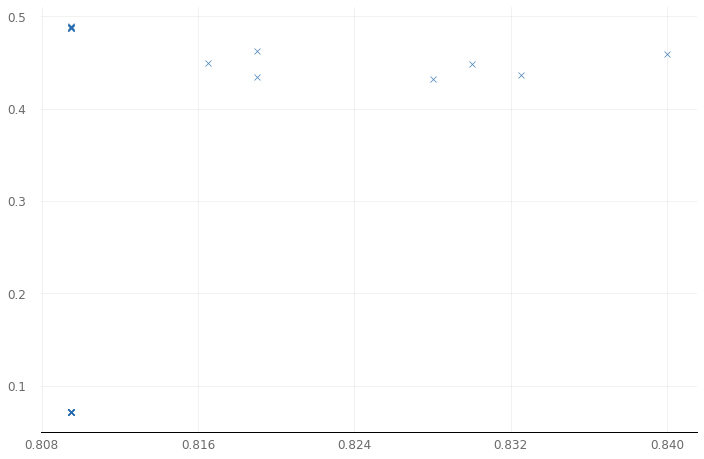

In [ ]:
# a regression plot for two dimensions 
analyze_object.plot_regs('val_accuracy', 'val_loss')

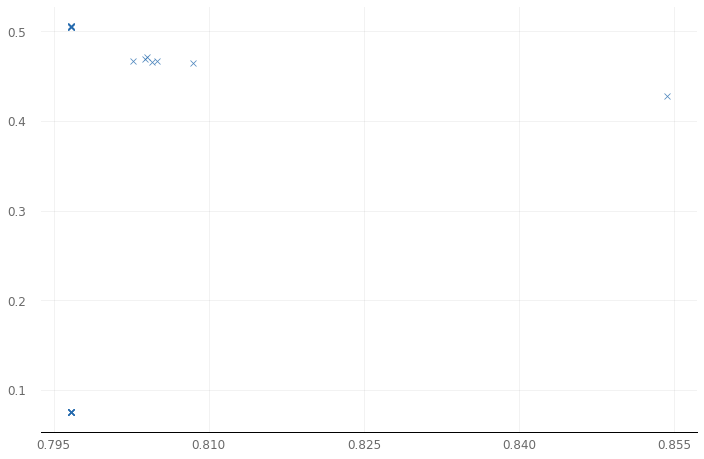

In [ ]:
# a regression plot for two dimensions 
analyze_object.plot_regs('accuracy', 'loss')

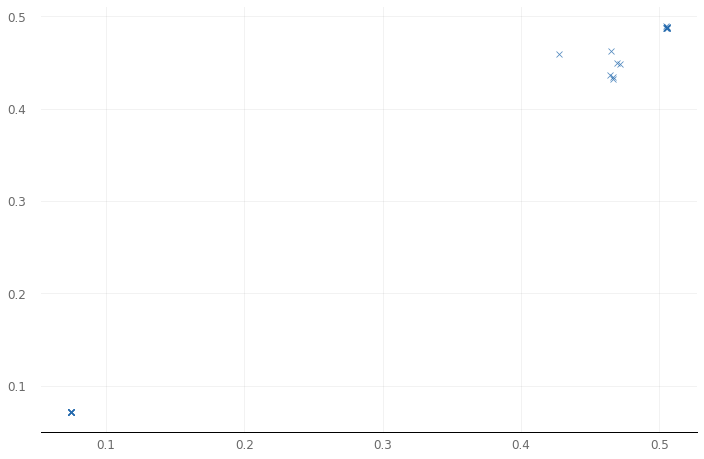

In [ ]:
# a regression plot for two dimensions 
analyze_object.plot_regs('loss', 'val_loss')

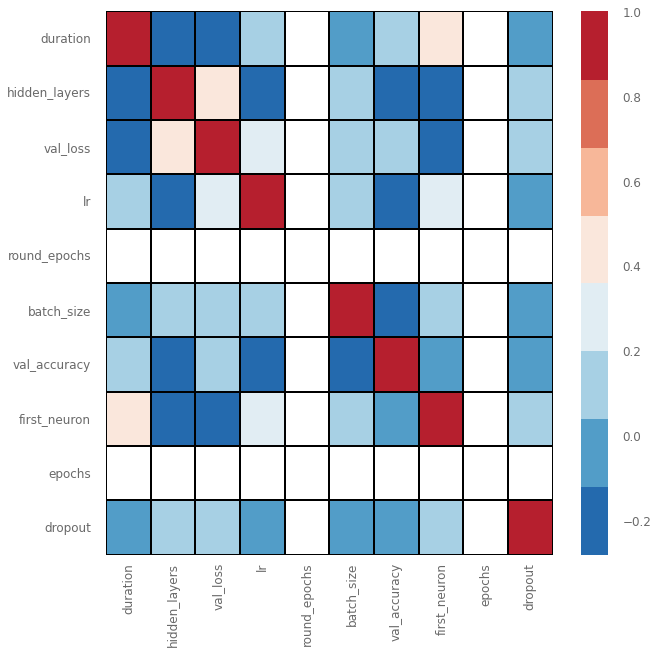

In [ ]:
# heatmap correlation
analyze_object.plot_corr('val_loss', ['accuracy', 'loss', 'val_loss'])

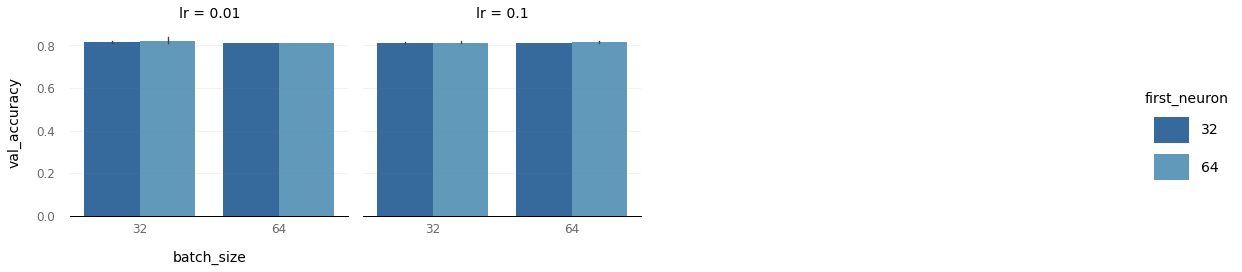

In [ ]:
# a four dimensional bar grid
analyze_object.plot_bars('batch_size', 'val_accuracy', 'first_neuron', 'lr')

In [ ]:
evaluate_object = ta.Evaluate(scan_object)
evaluate_object.evaluate(X_train, Y_train, folds=10, metric='loss', task='continuous', asc = True)

25/25 [==============================] - 0s 2ms/step


[0.30272125035524367,
 0.30606495797634126,
 0.3010493965446949,
 0.30272125035524367,
 0.2868386391550303,
 0.30606495797634126,
 0.2860027122497559,
 0.29937754273414613,
 0.3127523732185364,
 0.2910182736814022]

In [ ]:
evaluate_object.evaluate(X_test, Y_test, folds=10, metric='val_loss', task='continuous', asc = True, shuffle = False)

7/7 [==============================] - 0s 2ms/step


[0.35622057229280474,
 0.3194397884607315,
 0.32278349608182905,
 0.292690127491951,
 0.292690127491951,
 0.3094086655974388,
 0.32612720370292664,
 0.3160960808396339,
 0.29603383511304854,
 0.2826590046286583]

In [ ]:
evaluate_object.evaluate(X_train, Y_train, folds=7, metric='accuracy', task='multi_class')

[0.44156479217603917,
 0.4426549536359199,
 0.4421104054714216,
 0.4499036608863199,
 0.44670542635658916,
 0.4423828125,
 0.4453618261291889]

In [ ]:
evaluate_object.evaluate(X_test, Y_test, folds=7, metric='val_accuracy', task='multi_class')

[0.43339960238568587,
 0.4265593561368209,
 0.44874274661508706,
 0.4265593561368209,
 0.44874274661508706,
 0.4411764705882353,
 0.44660194174757284]

In [ ]:
ta.Deploy(scan_object=scan_object, model_name='churn_deploy2', metric='val_accuracy');

Deploy package churn_deploy2 have been saved.


In [ ]:
churn = ta.Restore('churn_deploy2.zip')

In [ ]:
# make predictions with the model
predictions = churn.model.predict(X_test)
predictions

63/63 [==============================] - 0s 3ms/step


array([[0.55791146],
       [0.32276145],
       [0.21035355],
       ...,
       [0.3219514 ],
       [0.75235254],
       [0.18936513]], dtype=float32)

In [ ]:
# get the meta-data for the experiment
churn.details

,0,1
0,NaN,0
1,experiment_name,churn
2,random_method,quantum
3,reduction_method,NaN
4,reduction_interval,50
5,reduction_window,20
6,reduction_threshold,0.2
7,reduction_metric,val_acc
8,experiment_id,110722132915
9,complete_time,11/07/22/13:45


In [ ]:
# sample of x data
churn.x

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.836255,-0.183251,-0.350204,-1.225848,0.807737,-0.091202,1.0,-1.0,1.0,0.0,0.0,0.0,1.0
1,-0.450383,0.102810,-1.387538,0.577914,-0.911583,-1.395433,1.0,1.0,0.0,0.0,1.0,0.0,1.0
2,-0.988415,-0.755372,1.032908,1.112119,-0.911583,0.650366,1.0,-1.0,1.0,0.0,0.0,0.0,1.0
3,-0.740092,0.007457,-0.695982,1.442685,0.807737,-0.108761,1.0,-1.0,1.0,0.0,0.0,1.0,0.0
4,1.774174,1.056346,0.687130,-1.225848,0.807737,-1.565487,1.0,1.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-1.888585,-1.041433,-0.695982,-1.225848,0.807737,1.227155,1.0,-1.0,0.0,0.0,1.0,0.0,1.0
96,0.149730,0.293517,-1.041760,1.280337,0.807737,0.985690,-1.0,1.0,0.0,0.0,1.0,1.0,0.0
97,0.573948,-0.946079,-1.041760,-1.225848,0.807737,-1.423024,1.0,1.0,0.0,0.0,1.0,0.0,1.0
98,1.329263,-0.660018,1.724464,0.067991,-0.911583,-0.239681,1.0,-1.0,1.0,0.0,0.0,0.0,1.0


In [ ]:
# sample of y data
churn.y

,0
0,0
1,0
2,0
3,0
4,0
...,...
95,0
96,1
97,0
98,0


In [ ]:
# the results dataframe
churn.results

,start,end,duration,round_epochs,loss,accuracy,val_loss,val_accuracy,lr,first_neuron,...,batch_size,epochs,dropout,weight_regulizer,emb_output_dims,shape,optimizer,losses,activation,last_activation
0,11/07/22-132922,11/07/22-133005,42.852551,51,0.464736,0.808500,0.436373,0.8325,0.10,64,...,32,100,0.0,GlorotNormal,NaN,long_funnel,Nadam,binary_crossentropy,elu,sigmoid
1,11/07/22-133006,11/07/22-133030,24.258456,51,0.505315,0.796667,0.487601,0.8095,0.01,32,...,64,100,0.0,HeNormal,NaN,brick,Adamax,binary_crossentropy,relu,sigmoid
2,11/07/22-133030,11/07/22-133058,27.890851,51,0.471682,0.804000,0.448358,0.8300,0.01,32,...,32,100,0.5,HeNormal,NaN,brick,Adam,binary_crossentropy,elu,sigmoid
3,11/07/22-133059,11/07/22-133126,27.440482,51,0.505352,0.796667,0.488024,0.8095,0.10,32,...,32,100,0.0,GlorotNormal,NaN,brick,Adam,binary_crossentropy,relu,sigmoid
4,11/07/22-133126,11/07/22-133209,42.646061,51,0.074764,0.796667,0.070856,0.8095,0.10,64,...,32,100,0.5,HeNormal,NaN,brick,Nadam,logcosh,elu,sigmoid
5,11/07/22-133209,11/07/22-133237,27.782334,51,0.505402,0.796667,0.487853,0.8095,0.10,64,...,32,100,0.5,GlorotNormal,NaN,brick,Nadam,binary_crossentropy,relu,sigmoid
6,11/07/22-133238,11/07/22-133302,24.052564,51,0.074719,0.796667,0.070888,0.8095,0.10,64,...,32,100,0.0,HeNormal,NaN,brick,Adamax,logcosh,elu,sigmoid
7,11/07/22-133302,11/07/22-133345,42.660599,51,0.465356,0.804500,0.462804,0.8190,0.01,32,...,32,100,0.0,HeNormal,NaN,long_funnel,Nadam,binary_crossentropy,elu,sigmoid
8,11/07/22-133345,11/07/22-133413,27.923140,51,0.505603,0.796667,0.488069,0.8095,0.10,32,...,32,100,0.5,GlorotNormal,NaN,brick,Nadam,binary_crossentropy,relu,sigmoid
9,11/07/22-133413,11/07/22-133455,41.843487,51,0.074689,0.796667,0.070853,0.8095,0.10,64,...,32,100,0.0,GlorotNormal,NaN,brick,Adamax,logcosh,elu,sigmoid


In [ ]:
# Using 'auto'/'sum_over_batch_size' reduction type.
mse = tf.keras.losses.MeanSquaredError()
mse(Y_test, predictions).numpy()

0.24251989

In [ ]:
# Using 'none' reduction type.
mse1 = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
mse1(Y_test, predictions).numpy()

array([0.28601575, 0.18145093, 0.17053448, ..., 0.1812819 , 0.45600855,
       0.17129593], dtype=float32)

***First Model After Optimization***

---



In [ ]:
#after using keras and talos, uninstall the old version that is independent from tensorflow then you can use the learning rate with the optimizer (overlapping version's problem)
pip uninstall keras

In [ ]:
#Defining/creating a sequential model and initilazing the weights using He normal initialization and using elu as an activation function
#and with Batch Normalization with Momentum defaults to 0.95
#The hyperparameter ε defaults to 0.005,
#The hyperparameter β defaults to an all-zeros vector
#The hyperparameter γ defaults to an all-ones vector
#compile the model using the optimizer Nadam and the logcosh as loss function
#fit the model with the mini-batch Gradient Descent using 32 batches and 51 epochs

model = Sequential()
model.add(Dense(64, kernel_initializer='HeNormal', kernel_regularizer=regularizers.l2(0.09), input_shape=(n_features,), activation='elu'))
BatchNormalization()
model.add(Dense(77, kernel_initializer='HeNormal', kernel_regularizer=regularizers.l2(0.08), activation='elu'))
BatchNormalization()
model.add(Dense(70, kernel_initializer='HeNormal', kernel_regularizer=regularizers.l2(0.07), activation='elu'))
BatchNormalization()
model.add(Dense(70,  kernel_initializer='HeNormal', kernel_regularizer=regularizers.l2(0.06), activation='elu'))
BatchNormalization()
model.add(Dense(63, kernel_initializer='HeNormal', activation='elu'))
BatchNormalization(
              momentum=0.95, 
              epsilon=0.005,
              center = True,
              scale = True,
              beta_initializer='zeros', 
              gamma_initializer='ones',
              moving_mean_initializer='zeros',
            moving_variance_initializer='ones',
            beta_regularizer=None,
            gamma_regularizer=None,
            beta_constraint=None,
            gamma_constraint=None,
            ),
model.add(Dense(1, activation='sigmoid', name="predictions"))

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 64)                896       
_________________________________________________________________
dense_32 (Dense)             (None, 77)                5005      
_________________________________________________________________
dense_33 (Dense)             (None, 70)                5460      
_________________________________________________________________
dense_34 (Dense)             (None, 70)                4970      
_________________________________________________________________
dense_35 (Dense)             (None, 63)                4473      
_________________________________________________________________
predictions (Dense)          (None, 1)                 64        
Total params: 20,868
Trainable params: 20,868
Non-trainable params: 0
__________________________________________________

In [ ]:
#compile the model using the optimizer Nadam with learning rate equal 0.01 and the logcosh as loss function
opt = Nadam(learning_rate=0.01)
model.compile(optimizer = opt, loss='logcosh', metrics=['accuracy'])

In [ ]:
#We call model.fit() to fit our model to the training data:
history = model.fit(
    X_train, 
    Y_train, 
    epochs=51, 
    validation_split=0.25,
    batch_size=32, 
    verbose=2,
    validation_data=(X_test, Y_test)
)

Epoch 1/51
188/188 - 3s - loss: 0.0905 - accuracy: 0.7998 - val_loss: 0.0928 - val_accuracy: 0.7970
Epoch 2/51
188/188 - 1s - loss: 0.0903 - accuracy: 0.7998 - val_loss: 0.0910 - val_accuracy: 0.7970
Epoch 3/51
188/188 - 1s - loss: 0.0899 - accuracy: 0.7998 - val_loss: 0.0912 - val_accuracy: 0.7970
Epoch 4/51
188/188 - 1s - loss: 0.0899 - accuracy: 0.7998 - val_loss: 0.0906 - val_accuracy: 0.7970
Epoch 5/51
188/188 - 1s - loss: 0.0894 - accuracy: 0.7998 - val_loss: 0.0904 - val_accuracy: 0.7970
Epoch 6/51
188/188 - 1s - loss: 0.0894 - accuracy: 0.7998 - val_loss: 0.0906 - val_accuracy: 0.7970
Epoch 7/51
188/188 - 1s - loss: 0.0893 - accuracy: 0.7998 - val_loss: 0.0906 - val_accuracy: 0.7970
Epoch 8/51
188/188 - 1s - loss: 0.0891 - accuracy: 0.7998 - val_loss: 0.0901 - val_accuracy: 0.7970
Epoch 9/51
188/188 - 1s - loss: 0.0890 - accuracy: 0.7998 - val_loss: 0.0903 - val_accuracy: 0.7970
Epoch 10/51
188/188 - 1s - loss: 0.0889 - accuracy: 0.7998 - val_loss: 0.0902 - val_accuracy: 0.7970

In [ ]:
#evaluate the model in training model:
loss, acc = model.evaluate(X_train, Y_train, batch_size=128, verbose=2)
print('Train Accuracy: %.3f' % acc)

63/63 - 0s - loss: 0.0740 - accuracy: 0.7999
Train Accuracy: 0.800


In [ ]:
#To evaluate the model on the test set:
loss, acc = model.evaluate(X_test, Y_test, batch_size=128, verbose=2)
print('Test Accuracy: %.3f' % acc)

16/16 - 0s - loss: 0.0789 - accuracy: 0.7820
Test Accuracy: 0.782


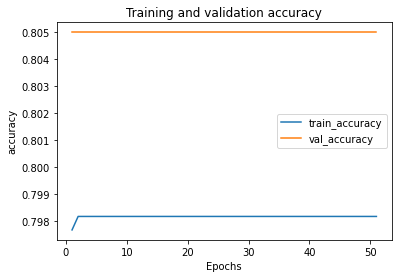

In [ ]:
#Plotting training and validation accuracy to observe how the accuracy of our model improves over time:
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()
  
plot_metric(history, 'accuracy')

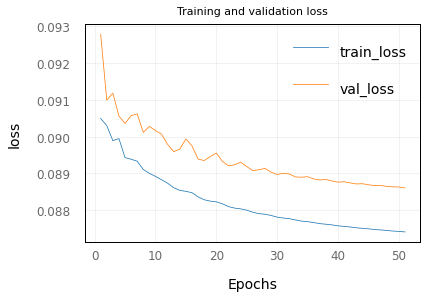

In [ ]:
#By running plot_metric(history, 'loss') to plot the progress on loss:
plot_metric(history, 'loss')

***Second Model After Optimization***

In [ ]:
#Defining/creating a sequential model and initilazing the weights using Glorot Normal (Xavier) initialization and using relu as an activation function
#and with Batch Normalization with Momentum defaults to 0.95
#The hyperparameter ε defaults to 0.005,
#The hyperparameter β defaults to an all-zeros vector
#The hyperparameter γ defaults to an all-ones vector
#compile the model using the optimizer Adam with learning rate equal 0.1 and the logcosh as loss function
#fit the model with the mini-batch Gradient Descent using 32 batches and 51 epochs

model = Sequential()
model.add(Dense(32, kernel_initializer='GlorotNormal', kernel_regularizer=regularizers.l2(0.1), input_shape=(n_features,), activation='relu'))
BatchNormalization()
model.add(Dense(77, kernel_initializer='GlorotNormal', kernel_regularizer=regularizers.l2(0.08), activation='relu'))
BatchNormalization()
model.add(Dense(70, kernel_initializer='GlorotNormal', kernel_regularizer=regularizers.l2(0.08), activation='relu'))
BatchNormalization()
model.add(Dense(70,  kernel_initializer='GlorotNormal', kernel_regularizer=regularizers.l2(0.1), activation='relu'))
BatchNormalization()
model.add(Dense(63, kernel_initializer='GlorotNormal', activation='relu'))
BatchNormalization(
              momentum=0.95, 
              epsilon=0.005,
              center = True,
              scale = True,
              beta_initializer='zeros', 
              gamma_initializer='ones',
              moving_mean_initializer='zeros',
            moving_variance_initializer='ones',
            beta_regularizer=None,
            gamma_regularizer=None,
            beta_constraint=None,
            gamma_constraint=None,
            ),
model.add(Dense(1, activation='sigmoid', name="predictions"))

#compile the model using the optimizer Nadam and the categorical crossentropy as loss
opt = Adam(learning_rate=0.1)
model.compile(optimizer = opt, loss='logcosh', metrics=['accuracy'])

#We call model.fit() to fit our model to the training data:
history = model.fit(
    X_train, 
    Y_train, 
    epochs=51, 
    validation_split=0.25,
    batch_size=32, 
    verbose=2,
    validation_data=(X_test, Y_test)
)

Epoch 1/51
188/188 - 1s - loss: 0.4679 - accuracy: 0.7967 - val_loss: 0.0723 - val_accuracy: 0.8050
Epoch 2/51
188/188 - 0s - loss: 0.0744 - accuracy: 0.7982 - val_loss: 0.0723 - val_accuracy: 0.8050
Epoch 3/51
188/188 - 1s - loss: 0.0744 - accuracy: 0.7982 - val_loss: 0.0722 - val_accuracy: 0.8050
Epoch 4/51
188/188 - 1s - loss: 0.0744 - accuracy: 0.7982 - val_loss: 0.0722 - val_accuracy: 0.8050
Epoch 5/51
188/188 - 1s - loss: 0.0744 - accuracy: 0.7982 - val_loss: 0.0723 - val_accuracy: 0.8050
Epoch 6/51
188/188 - 1s - loss: 0.0744 - accuracy: 0.7982 - val_loss: 0.0724 - val_accuracy: 0.8050
Epoch 7/51
188/188 - 1s - loss: 0.0751 - accuracy: 0.7982 - val_loss: 0.0763 - val_accuracy: 0.8050
Epoch 8/51
188/188 - 1s - loss: 0.0840 - accuracy: 0.7982 - val_loss: 0.0795 - val_accuracy: 0.8050
Epoch 9/51
188/188 - 1s - loss: 0.0815 - accuracy: 0.7982 - val_loss: 0.0801 - val_accuracy: 0.8050
Epoch 10/51
188/188 - 0s - loss: 0.0820 - accuracy: 0.7982 - val_loss: 0.0788 - val_accuracy: 0.8050

In [ ]:
#evaluate the model in training model:
loss, acc = model.evaluate(X_train, Y_train, batch_size=128, verbose=1)
print('Train Accuracy: %.3f' % acc)

63/63 [==============================] - 0s 2ms/step - loss: 0.0797 - accuracy: 0.7999
Train Accuracy: 0.800


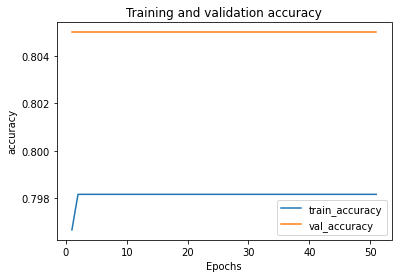

In [ ]:
#Plotting training and validation accuracy to observe how the accuracy of our model improves over time:
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()
  
plot_metric(history, 'accuracy')

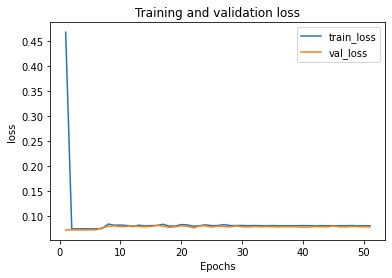

In [ ]:
#By running plot_metric(history, 'loss') to plot the progress on loss:
plot_metric(history, 'loss')

***Third Model After Optimization***

In [ ]:
#initilazing the weights using Xavier normal initialization (GlorotNormal) in a layer and He Normal initialization in another and using relu as an activation function for a layer and elu for the next layer
#and with Batch Normalization with Momentum defaults to 0.8
#The hyperparameter ε defaults to 0.001,
#The hyperparameter β defaults to an all-zeros vector
#The hyperparameter γ defaults to an all-ones vector
#compile the model using the optimizer Adamax with learning rate equal 0.001 and the logcosh as loss function
#fit the model with the mini-batch Gradient Descent using 64 batches and 51 epochs


model = Sequential()
model.add(Dense(100, kernel_initializer='GlorotNormal', kernel_regularizer=regularizers.l2(0.01), input_shape=(n_features,), activation='relu'))
BatchNormalization()
model.add(Dense(77, kernel_initializer='HeNormal', kernel_regularizer=regularizers.l2(0.05), activation='elu'))
BatchNormalization()
model.add(Dense(70, kernel_initializer='GlorotNormal', kernel_regularizer=regularizers.l2(0.09), activation='relu'))
BatchNormalization()
model.add(Dense(70,  kernel_initializer='HeNormal', kernel_regularizer=regularizers.l2(0.11), activation='elu'))
BatchNormalization()
model.add(Dense(63, kernel_initializer='GlorotNormal', activation='relu'))
BatchNormalization(
              momentum=0.8, 
              epsilon=0.001,
              center = True,
              scale = True,
              beta_initializer='zeros', 
              gamma_initializer='ones',
              moving_mean_initializer='zeros',
              moving_variance_initializer='ones',
              beta_regularizer=None,
              gamma_regularizer=None,
              beta_constraint=None,
              gamma_constraint=None,
            ),
model.add(Dense(1, activation='sigmoid', name="predictions"))

#compile the model using the optimizer Nadam and the categorical crossentropy as loss
opt = Adamax(learning_rate=0.001)
model.compile(optimizer = opt, loss='logcosh', metrics=['accuracy'])

#We call model.fit() to fit our model to the training data:
history = model.fit(
    X_train, 
    Y_train, 
    epochs=51, 
    validation_split=0.25,
    batch_size=64, 
    verbose=2,
    validation_data=(X_test, Y_test)
)

Epoch 1/51
94/94 - 1s - loss: 18.8845 - accuracy: 0.7977 - val_loss: 11.0415 - val_accuracy: 0.8050
Epoch 2/51
94/94 - 0s - loss: 7.2019 - accuracy: 0.7982 - val_loss: 4.3320 - val_accuracy: 0.8050
Epoch 3/51
94/94 - 0s - loss: 2.8435 - accuracy: 0.7982 - val_loss: 1.7168 - val_accuracy: 0.8050
Epoch 4/51
94/94 - 0s - loss: 1.1314 - accuracy: 0.7982 - val_loss: 0.6879 - val_accuracy: 0.8050
Epoch 5/51
94/94 - 0s - loss: 0.4630 - accuracy: 0.7982 - val_loss: 0.2925 - val_accuracy: 0.8050
Epoch 6/51
94/94 - 0s - loss: 0.2101 - accuracy: 0.7982 - val_loss: 0.1465 - val_accuracy: 0.8050
Epoch 7/51
94/94 - 0s - loss: 0.1188 - accuracy: 0.7982 - val_loss: 0.0956 - val_accuracy: 0.8050
Epoch 8/51
94/94 - 0s - loss: 0.0879 - accuracy: 0.7982 - val_loss: 0.0790 - val_accuracy: 0.8050
Epoch 9/51
94/94 - 0s - loss: 0.0781 - accuracy: 0.7982 - val_loss: 0.0740 - val_accuracy: 0.8050
Epoch 10/51
94/94 - 0s - loss: 0.0752 - accuracy: 0.7982 - val_loss: 0.0727 - val_accuracy: 0.8050
Epoch 11/51
94/94

In [ ]:
#evaluate the model in training model:
loss, acc = model.evaluate(X_train, Y_train, batch_size=128, verbose=1)
print('Train Accuracy: %.3f' % acc)

63/63 [==============================] - 0s 2ms/step - loss: 0.0737 - accuracy: 0.7999
Train Accuracy: 0.800


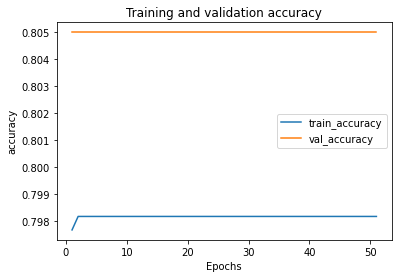

In [ ]:
#Plotting training and validation accuracy to observe how the accuracy of our model improves over time:
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()
  
plot_metric(history, 'accuracy')

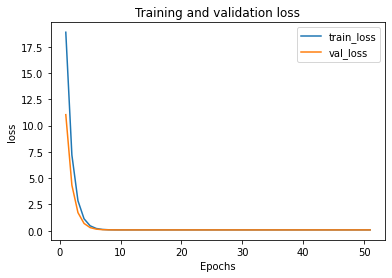

In [ ]:
#By running plot_metric(history, 'loss') to plot the progress on loss:
plot_metric(history, 'loss')